In [1]:
from nltk.corpus import movie_reviews
import random
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from tinycp.classifier import BinaryMarginalConformalClassifier, BinaryClassConditionalConformalClassifier
from sklearn.utils.validation import check_is_fitted
random.seed(42)
from tinycp.plot import efficiency_curve, reliability_curve, histogram, confusion_matrix, beta_pdf_with_cdf_fill
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/heylucasleao/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)
texts = [" ".join(words) for words, label in documents]
labels = [label for words, label in documents]

In [ ]:
df = pd.DataFrame({'Text': texts, 'Sentiment': labels})
df = pd.concat([df[df['Sentiment'] == 'pos'], df[df['Sentiment'] == 'neg'].sample(frac=0.15, random_state=42)])
df["Sentiment"] = df["Sentiment"].replace({"pos": 1, "neg": 0})
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment'])

/tmp/ipykernel_43436/3921306407.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Sentiment"] = df["Sentiment"].replace({"pos": 1, "neg": 0})


In [ ]:
class SentimentAnalyzer:
    """
    A class for sentiment analysis using a machine learning model with TF-IDF vectorization.

    Attributes:
        tfidf (TfidfVectorizer): An instance of TfidfVectorizer for text vectorization.
        is_fitted_ (bool): A flag indicating whether the model has been fitted.
        learner (object): The machine learning model used for sentiment analysis.

    Methods:
        __getattr__(attr):
            Delegates attribute access to the underlying learner if the attribute exists.

        fit(X_train, y_train):
            Fits the TF-IDF vectorizer and the learner to the training data.

        transform(X_test):
            Transforms the test data using the fitted TF-IDF vectorizer.

        predict_proba(X_test):
            Predicts probabilities for the test data using the learner.

        predict(X_test):
            Predicts labels for the test data using the learner.
    """
    def __init__(self, learner):
        """
        Initializes the SentimentAnalyzer with a machine learning model.

        Args:
            learner (object): The machine learning model to be used for sentiment analysis.
        """
        self.tfidf = TfidfVectorizer()
        self.is_fitted_ = False
        self.learner = learner
        
    def __getattr__(self, attr):
        """
        Delegates attribute access to the underlying learner if the attribute exists.

        Args:
            attr (str): The attribute name.

        Returns:
            object: The attribute value from the learner.

        Raises:
            AttributeError: If the attribute does not exist in the learner.
        """
        if hasattr(self.learner, attr):
            return getattr(self.learner, attr)
        raise AttributeError(f"'{self.__class__.__name__}' does not have the attribute '{attr}'")
    
    def fit(self, X, y):
        """
        Fits the TF-IDF vectorizer and the learner to the training data.

        Args:
            X (iterable): The training data (text).
            y (iterable): The training labels.

        Returns:
            object: The fitted learner.
        """
        X = self.tfidf.fit_transform(X)
        self.learner.fit(X, y)
        self.is_fitted_ = True
        return self.learner

    def transform(self, X):
        """Transforms test data using the fitted TF-IDF vectorizer."""
        return self.tfidf.transform(X)
    
    def predict_proba(self, X):
        """Predicts probabilities for test data using the learner."""
        return self.learner.predict_proba(self.transform(X))
    
    def predict(self, X):
        """Predicts labels for test data using the learner."""
        return self.learner.predict(self.transform(X))


In [5]:
learner = RandomForestClassifier(
            random_state=42, 
            oob_score=True, 
            n_jobs=-1, 
            class_weight="balanced", 
            max_depth=int(np.ceil(np.log2(len(X_train)) - 1)),
            min_samples_leaf=5
        )

In [6]:
model = SentimentAnalyzer(learner)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=5,
                       n_jobs=-1, oob_score=True, random_state=42)

In [7]:
clf = BinaryClassConditionalConformalClassifier(model)
clf.fit(y=y_train.values, oob=True)

In [8]:
clf.calibrate(
    X_train, 
    y_train, 
    func="bm",
    max_alpha=0.3)

0.29

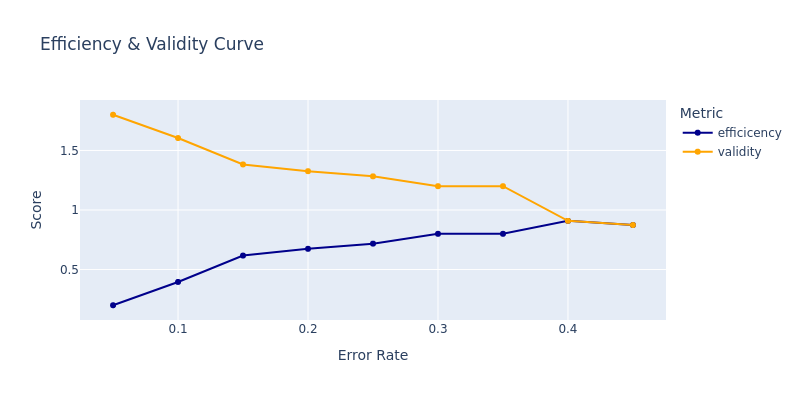

In [9]:
efficiency_curve(clf, X_test, fig_type="png")

In [10]:
clf.evaluate(X_test, y_test)

{'total': 230,
 'alpha': 0.29,
 'coverage_rate': 0.878,
 'one_c': 0.8,
 'avg_c': 1.2,
 'empty': 0.0,
 'error': 0.122,
 'log_loss': 0.317,
 'ece': 0.034,
 'bm': 0.462,
 'mcc': 0.323,
 'f1': 0.803,
 'fpr': 0.233}

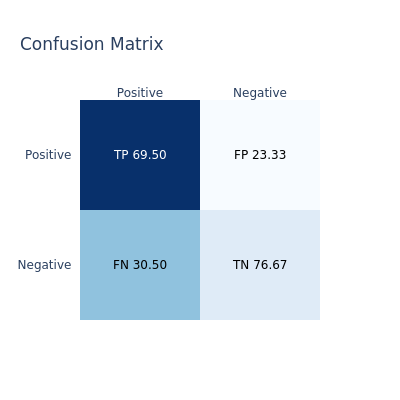

In [12]:
confusion_matrix(clf, X_test, y_test, fig_type="png")